In [1]:
import sys
sys.path.append('..')
import numpy as np
import pickle
from scipy.io import savemat
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

from utils import *
from scipy.stats import zscore

### Load data

In [2]:
srate = 240
expName = 'sweep'

dir = '../datasets/%s.pickle' % expName
winLENs = np.arange(0.2, 1, step=.2)
with open(dir, "rb") as fp:
    wholeset = pickle.load(fp)

sub = wholeset[0]

chnNames = ['PZ', 'PO5', 'POZ', 'PO4', 'PO6', 'O1', 'OZ']
chnINX = [sub['channel'].index(i) for i in chnNames]
X = sub['wn']['X'][:,chnINX]
y = sub['wn']['y']
STI = sub['wn']['STI']

sub['name']

'chenyuzhen'

_Variable defination_:
- $X$: EEG data, shape as $epoch \times channel \times T$
- $S$: STI sequence, shape as $class \times T$
- $y$: Event labels, shape as $epoch \times 1$

## Extract Evoked Response

### define model parameters

In [3]:
from forwardModeling import Code2EEG
srate = 240
winLEN = 1 
classNUM = 160

tmin, tmax = 0, 1
# penalty
p = 0.99
code2EEG = Code2EEG(srate=240,tmin=tmin,tmax=tmax,S=(STI,np.unique(y)),estimator=p)
code2EEG.fit(X,y)
R_ = code2EEG.predict(STI)

/Users/shinanlin/opt/anaconda3/lib/python3.8/site-packages/mne/decoding/receptive_field.py:427: RuntimeWarning: Mean of empty slice.
  out[:] += (mean_value - use_X.mean(axis=0))
/Users/shinanlin/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


In [11]:
code2EEG.enhanced.shape

(160, 5, 240)

In [16]:
Rho = []
for evoked in code2EEG.enhanced[:,0]:
    for r in R_[:,0]:
        rho = np.corrcoef(evoked,r)
        Rho.append(rho[0,1])

In [17]:
Rho = np.stack(Rho)
Rho.shape

(25600,)

In [28]:
rs = np.reshape(Rho,(160,160),order='F')
rs.shape

(160, 160)

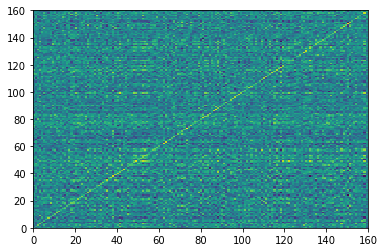

In [31]:
plt.pcolor(rs)

_Variable defination_:
- $enhanced$: enhanced repsonse, shape as $Epoch \times Channel \times T$.

Reconstruct ehanced response instead of single trial EEG


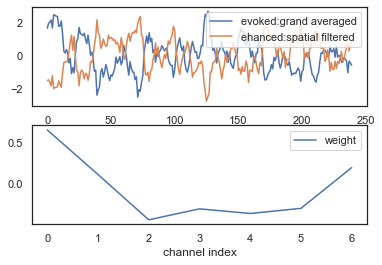

In [35]:
inx = 6
sns.set_theme(style='white')
f,(ax1,ax2) = plt.subplots(nrows=2,ncols=1)
ax1.plot(zscore(enhanced[0, inx]),label='evoked:grand averaged')
ax1.plot(zscore(enhance.evokeds[inx, 0].mean(axis=(0))),label='ehanced:spatial filtered')
ax1.legend()

ax2.plot(enhance.filter[0,:,inx],label='weight')
ax2.legend()
ax2.set_xlabel('channel index')
plt.show()

## Build a forward model: Code2EEG

In [ ]:
from forwardModeling import ForwardModel

tmin, tmax = 0, 0.4
# penalty
p = 1e4
R = enhanced.transpose((1,0,-1))
code2eeg = ForwardModel(sfreq=srate, tmin=tmin, tmax=tmax, estimator=p)
code2eeg.fit(S=STI, R=R, y=np.unique(y))

code2eeg model stores two attributes:

- _**code2eeg.kernels**_: TRF for each stimulation pattern, shape as $class \times trial \times channel \times lags$
- _**code2eeg.trf**_: averaged TRF

we can visualize by:

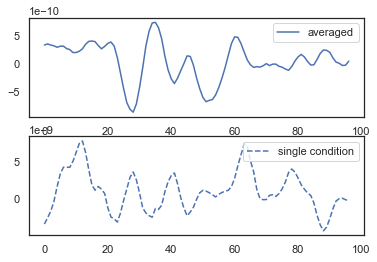

In [46]:
sns.set_theme(style='white')
f,(ax1,ax2) = plt.subplots(2,1)
ax1.plot(code2eeg.trf.squeeze(),label='averaged')
ax2.plot(code2eeg.kernels.squeeze()[0],label='single condition',linestyle='dashed')
ax1.legend()
ax2.legend()
plt.show()

After feed the code2eeg model with training data, we can then predict the unseen response by: `predict()`

In [19]:
s = STI[20,:]
r = code2eeg.predict(s[np.newaxis,:])

In [20]:
rs = code2eeg.recon.squeeze()

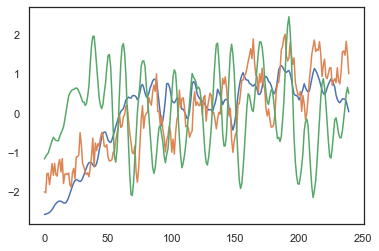

In [21]:
plt.plot(zscore(rs[20]))
plt.plot(zscore(R[20].T))
plt.plot(zscore(r.squeeze()))